In [1]:
import os
import pickle
import json
from random import shuffle
from collections import defaultdict

import numpy as np
import scipy
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

# Raw data location

**In order to run this notebook, you need to first download the raw data from Dryad.**  
https://doi.org/10.5061/dryad.bnzs7h4c4

```DATA_DIR``` in the cell below must provide a path to the raw data folder.

In [2]:
DATA_DIR = 'raw_data' # <--- Fill in after downloading the raw data.

#  
## Plotting utilities

In [3]:
# Potential color choices
plot_cols = {
    'Free Market':  [121, 142, 173],
    'US Federal':   [185, 127, 115],
    'Saez Formula': [255, 184,   0],
    'AI Economist': [  0, 165, 201],
    'AI Economist (early)': np.ones(3) * .3,
    'Ego-Democratic AI Economist': [  144, 112, 200],
    'Considerate-Democratic AI Economist 50': [185, 127, 115],
    'Considerate-Democratic AI Economist 100': [121, 142, 173],
    'Considerate-Democratic AI Economist 00': [255, 0, 0],
}

plot_cols = {k: np.array(v)/255. for k, v in plot_cols.items()}

In [4]:
# Convenience functions    
def clean_ax_box(fig, keep_bottom_ticks=True):
    for ax in fig.get_axes():
        for sk, spine in ax.spines.items():
            spine.set_visible(sk in ['left', 'bottom'])
        ax.tick_params(top=False, bottom=keep_bottom_ticks)
        
def set_figure_tick_sizes(fig, x=None, y=None):
    for ax in fig.get_axes():
        if x is not None:
            for label in ax.get_xticklabels():
                label.set_fontsize(float(x))
        if y is not None:
            for label in ax.get_yticklabels():
                label.set_fontsize(float(y))
                
def set_figure_label_sizes(fig, x=None, y=None, t=None):
    for ax in fig.get_axes():
        if x is not None:
            ax.xaxis.label.set_fontsize(float(x))
        if y is not None:
            ax.yaxis.label.set_fontsize(float(y))
        if t is not None:
            ax.title.set_fontsize(float(t))
            
def clean_figure(fig=None):
    if fig is None:
        fig = plt.gcf()
        
    clean_ax_box(fig)
    set_figure_label_sizes(fig, x=14, y=14, t=14)
    set_figure_tick_sizes(fig, x=10, y=14)

#  
# Load Data 
## Load training history data

There is training history data for each scenario, at ```<DATA_DIR>/<scenario>/training_history.pkl```.

History is stored as a dictionary of ```{group_key: {'type': string, 'data': list-of-dictionaries}```.
You will notice that for every run group (each seperate sub-directory in ```<DATA_DIR>/<scenario>/```), there is a ```group_key``` in the training dictionary.
The ```list-of-dictionaries``` is a list with one element for each run (each seperate sub-directory in ```<DATA_DIR>/<scenario>/<group_key>```).
Each element is a dictionary of ```{metric: list}``` where ```metric``` is the name of a given metric tracked during training (i.e. "Productivity") and the list is the list of values throughout training.
The key ```Environment Steps``` specifies how many environment steps had occured at each point in the list of values.
Each metric's list is the same length.

In [13]:
def load_training_history(scenario):
    training_history_path = os.path.join(DATA_DIR, scenario, 'training_history.pkl')
    
    with open(training_history_path, 'rb') as f:
        training_history = pickle.load(f)
        
    return training_history

In [14]:
# One step economy
one_step_history = load_training_history('one_step_economy')

# Open Quad w/ 4 agents
quad_4_history = load_training_history('open_quadrant_4')

# Open Quad w/ 10 agents
quad_10_history = load_training_history('open_quadrant_10')

# Split World (10 agents) w/ skill ranks 0, 1, 2 in top half
split_012_history = load_training_history('split_012')

# Split World (10 agents) w/ skill ranks 2, 7 in top half
split_27_history = load_training_history('split_27')

# Split World (10 agents) w/ skill ranks 4, 5 in top half
split_45_history = load_training_history('split_45')

# Split World (10 agents) w/ skill ranks 7, 8, 9 in top half
split_789_history = load_training_history('split_789')

## Load pre-processed statistics from dense logs

This notebook, by default, loads in the pre-processed data used in the paper. This is located in the same directory as this notebook, at:  
```preprocessed_dense_logs_stats_dict-open_quadrant_4-eq_times_prod-used_in_paper_analyses.pkl```.

If you would like to analyze a different scenario/objective, you can preprocess the dense logs in the accompanying notebook at:  
```Process-dense-logs.ipynb```. **You will then need to adjust the path in the next cell.**  
It may also be helpful to review this notebook to better understand the structure of the pre-processed statistics dictionaries.

In [7]:
# Load preprocssed statistics from episode dense logs. Paper plots refer to stats from 4-agent Open Quadrant.
with open('preprocessed_dense_logs_stats_dict-open_quadrant_4-eq_times_prod-used_in_paper_analyses.pkl', 'rb') as f:
    quad_4_stats_dict = pickle.load(f)

In [8]:
# This specific log is referenced when plotting tax gaming.
with open('tax_gaming_reference_dense_log-ai_economist.json', 'r') as f:
    tax_gaming_dense_log = json.load(f)

#  
#  Plotting functions    
## Plotting functions based on training history

In [5]:
def training_curve_plot(
    training_history, run_sets, metric,
    label_x=True, ylabel=None, title=None,
    max_steps=None, plot_every=10, smooth_amount=50, scale=1,
    ax=None
):
    
    def smooth(data, amount=5):
        amount = int(amount)
        if amount < 0:
            raise ValueError
        elif amount == 0:
            return data
        cs = np.cumsum(data)
        return (cs[amount:]-cs[:-amount])/amount

    def big_number_converter(n):
        n = float(n)
        if n < 0:
            return n
        if n == 0:
            return '0'
        if n < 1e3:
            return str(int(n))
        if n < 1e6:
            return str(int(n/1e3)) + 'k'
        if n < 1e9:
            return str(int(n/1e6)) + 'M'
        return str(int(n/1e9)) + 'B'


    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 4))
        
    plot_every = int(plot_every)
    assert plot_every >= 1
        
    for run_set in run_sets:
        assert run_set in training_history
        assert 'data' in training_history[run_set]
        assert all([(metric in d) for d in training_history[run_set]['data']])
        assert all([('Environment Steps' in d) for d in training_history[run_set]['data']])
        
    for i, run_set in enumerate(run_sets):
        set_dict = training_history[run_set]
        
        step_metrics = defaultdict(lambda: [])
        
        for run_data in set_dict['data']:
            for s, m in zip(run_data['Environment Steps'], run_data[metric]):
                step_metrics[int(s)].append(float(m) * scale)
            #print(s)
                
        steps = np.sort(list(step_metrics.keys()))[::plot_every]
        
        if max_steps is not None:
            steps = steps[steps <= int(max_steps)]
            
        # print(len(step_metrics[s]))
        
        avgs = np.array([np.nanmean(step_metrics[s]) for s in steps])
        stes = np.array([np.nanstd(step_metrics[s])/np.sqrt(len(step_metrics[s])) for s in steps])
        
        # print(steps)
        
        avgs = smooth(avgs, smooth_amount)
        stes = smooth(stes, smooth_amount)
        steps = steps[:len(avgs)]
        
        # print(steps)
        
        ax.fill_between(steps, avgs-stes, avgs+stes, color=plot_cols[set_dict['type']], alpha=0.2)
        ax.plot(steps, avgs, color=plot_cols[set_dict['type']], linewidth=2, label=set_dict['type'])
        
        
    ax.set_xlim(left=0);
    if max_steps is not None:
        ax.set_xlim(right=int(max_steps));
        
    if label_x:
        ax.set_xticklabels([big_number_converter(xt) for xt in ax.get_xticks()], fontsize=14);
        ax.set_xlabel('Training Duration (Environment Steps)', fontsize=14)
    else:
        ax.set_xticklabels([]);
        ax.set_xlabel('');
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=14)    

    if title is not None:
        ax.set_title(title, fontsize=14)

In [6]:
def bar_plot_from_history(
    training_history, run_sets, metric, label_x_ticks=False, ylabel=None, title=None, ax=None, scale=1
):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
    for run_set in run_sets:
        assert run_set in training_history
        
    # Only one set per type
    set_types = [training_history[run_set]['type'] for run_set in run_sets]
    assert len(set_types) == len(set(set_types))
    
    out = {}
    out_ste = {}
    raw = {}

    for i, run_set in enumerate(run_sets):
        set_dict = training_history[run_set]
        
        xs = [np.mean(d[metric][-100:])*scale for d in set_dict['data']]
        ax.bar(i, np.mean(xs), color=plot_cols[set_dict['type']], label=set_dict['type'])
        
        raw[set_dict['type']] = xs
        out[set_dict['type']] = np.mean(xs)
        
        ax.errorbar(i, np.mean(xs), np.std(xs)/np.sqrt(len(xs)), color='k', linewidth=3);
        
        out_ste[set_dict['type']] = np.std(xs)/np.sqrt(len(xs))

    if label_x_ticks:
        ax.set_xticks(list(range(len(set_types))))
        if ax.is_last_row():
            ax.set_xticklabels(set_types, rotation=90, fontsize=14);
    else:
        ax.set_xticks([]);

    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=14)

    if title is not None:
        ax.set_title(title, fontsize=20)
        
    return out, out_ste, raw

def print_ttest(rawdata, label):
    print('\n{:<40}AI Economist:  {:7.3f}, ind. t-test p_value:'.format(label, np.mean(rawdata['AI Economist'])))
    for g, data in rawdata.items():
        if 'AI Economist' in g:
            continue
        ttest = scipy.stats.ttest_ind(rawdata['AI Economist'], data)
        print('{:>52}:  {:7.3f},  {:5.3e}'.format(g, np.mean(data), ttest.pvalue))
    print('')

In [7]:
def rate_plot_from_history(
    training_history, run_sets, title=None, label_y=True, label_x=True, ax=None, rectangle_alpha=0.035, **kwargs
):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
    for run_set in run_sets:
        assert run_set in training_history
        
    # Only one set per type
    set_types = [training_history[run_set]['type'] for run_set in run_sets]
    assert len(set_types) == len(set(set_types))
    
    # Bracket cutoffs -- in income (coin)
    xs = [0, 9, 39, 84, 160, 204, 510]
    xs += [xs[-1] * 1.1]
    
    bracket_keys = [
        'Avg. Bracket Rate: 0',
        'Avg. Bracket Rate: 9',
        'Avg. Bracket Rate: 39',
        'Avg. Bracket Rate: 84',
        'Avg. Bracket Rate: 160',
        'Avg. Bracket Rate: 204',
        'Avg. Bracket Rate: 510',
    ]

    for run_set in run_sets:
        set_dict = training_history[run_set]
        
        # Plot a line at 0% for the free market taxes
        if set_dict['type'] == 'Free Market':
            ax.plot([xs[0], xs[-1]], [0, 0], color=plot_cols['Free Market'], linewidth=2, **kwargs)
            continue
        
        # For each bracket
        for i, bracket_key in enumerate(bracket_keys):
            # Collect the mean end-of-training bracket rates across runs
            bracket_avgs = [
                np.mean(run_data[bracket_key][-10:]) for run_data in set_dict['data']
            ]
            bracket_avg = np.mean(bracket_avgs)
            
            # Plot the bracket
            rect = Rectangle((xs[i], 0), xs[i+1]-xs[i], bracket_avg*100, 
                             color=plot_cols[set_dict['type']], alpha=rectangle_alpha)
            ax.add_patch(rect);
            ax.plot([xs[i], xs[i+1]], [bracket_avg*100]*2,
                    color=plot_cols[set_dict['type']], linewidth=2, **kwargs)
            
    # Format the plot
    ax.set_ylim([0, 100]);
    ax.set_xlim([-5, xs[-1]]);
    ax.set_xticks(xs[1:-1])
    
    if label_x:
        ax.set_xticklabels(xs[1:-1], rotation=90, fontsize=14);
        ax.set_xlabel('Income (Coin)', fontsize=14)
    else:
        ax.set_xticklabels([])
        ax.set_xlabel('')

    if label_y:
        ax.set_ylabel('Marginal Tax Rate (%)', fontsize=14)

    if title is not None:
        ax.set_title(title, fontsize=20)

In [12]:
def eq_prod_scatter_from_history(training_history, run_sets, n_agents, title=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
    for run_set in run_sets:
        assert run_set in training_history
        
    # Only one set per type
    set_types = [training_history[run_set]['type'] for run_set in run_sets]
    assert len(set_types) == len(set(set_types))

    es = []
    ps = []
    e_errs = []
    p_errs = []
    
    for i, run_set in enumerate(run_sets):
        set_dict = training_history[run_set]
        
        each_e = np.array([np.mean(run_data['Income Equality'][-100:]) for run_data in set_dict['data']])*100
        each_p = np.array([np.mean(run_data['Productivity'][-100:]) for run_data in set_dict['data']])/n_agents
        
        e = each_e.mean()
        p = each_p.mean()
        e_err = each_e.std()/np.sqrt(len(each_e))
        p_err = each_p.std()/np.sqrt(len(each_p))  
        ax.errorbar(p, e, xerr=p_err, yerr=e_err, color='k', linewidth=1)
        ax.plot(p, e, 'o', color=plot_cols[set_dict['type']])

    if ax.is_last_row():
        ax.set_xlabel('Avg. Income (Coin)');

    if ax.is_first_col():
        ax.set_ylabel('Income Equality (%)')

    if ax.is_first_row() and title is not None:
        ax.set_title(title, fontsize=20)

## Plotting functions based on preprocessed dense logs statistics

In [13]:
def rate_plot_from_stats(stats_dict, groups, occupancy=False, title=None, label_x=True, label_y=True, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    # Bracket cutoffs
    xs = [0, 9, 39, 84, 160, 204, 510]
    xs += [xs[-1] * 1.1]
    
    for group in groups:
        group_episode_dicts = stats_dict[group]
        episode_rates = np.array(
            [episode_dict['avg_bracket_occupancy' if occupancy else 'avg_tax_schedule']
             for episode_dict in group_episode_dicts]
        )
        mean_rates = episode_rates.mean(0)
        
        for i, rate in enumerate(mean_rates):
            rect = Rectangle((xs[i], 0), xs[i+1]-xs[i], rate*100, color=plot_cols[group], alpha=0.035)
            ax.add_patch(rect);
            ax.plot([xs[i], xs[i+1]], [rate*100]*2, color=plot_cols[group], linewidth=2)
            
    ax.set_ylim([0, 100]);
    ax.set_xlim([-5, xs[-1]]);

    ax.set_xticks(xs[1:-1])
    ax.set_xticklabels(xs[1:-1], rotation=90, fontsize=14);
    if label_x:
        ax.set_xlabel('Income (Coin)', fontsize=14)

    if label_y:
        ax.set_ylabel('Income Frequency (%)' if occupancy else 'Marginal Tax Rate (%)', fontsize=14)

    if title is not None:
        ax.set_title(title, fontsize=20)

In [14]:
def agent_point_plot_from_stats(
    stats_dict, stat_key, groups, scale=1, ylabel=None, title=None, label_x=True, ax=None
):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    # Determine how to space the data for each group
    assert isinstance(groups, (list, tuple))
    n_groups = len(groups)
    assert n_groups >= 1
    if n_groups == 1:
        offsets = [0]
    else:
        offsets = np.linspace(0, 0.1*n_groups, n_groups)
        offsets = offsets - offsets.mean()
    
    # Confirm that this is a 4-agent scenario
    n_agents = len(stats_dict['Free Market'][0]['pre_tax_income'])
    if n_agents != 4:
        raise NotImplementedError('This plotting function is currently only configured for 4-agent scenarios.')
    x0s = np.arange(n_agents)
    
    min_y = 0 # Formating. For handling the y limit and 0-baseline.
    
    # For each group
    for offset, group in zip(offsets, groups):
        group_episode_dicts = stats_dict[group]
        
        # Get the agent-wise stat_key for each episode (in stats_dict, agents should be pre-sorted by build skill)
        agent_wise_episode_metrics = np.array(
            [episode_dict[stat_key] for episode_dict in group_episode_dicts]
        ) * scale
        # Confirm that there are n_agent numbers per episode -- that is, shape = [n_episodes, n_agents]
        assert agent_wise_episode_metrics.shape[1] == n_agents
        # Get agent-wise means/STDs
        agent_wise_metric_means = agent_wise_episode_metrics.mean(0)
        agent_wise_metric_stds = agent_wise_episode_metrics.std(0)
        
        # Plot
        ax.errorbar(
            x0s+offset,
            agent_wise_metric_means,
            yerr=agent_wise_metric_stds,
            fmt='none',
            ecolor='k',
        ),
        ax.plot(x0s+offset, agent_wise_metric_means, 'o', color=plot_cols[group]);
        
        min_y = np.minimum(min_y, np.min(agent_wise_metric_means))
        
    # Add a 0-baseline for visual clarity, if appropriate
    if min_y >= 0:
        ax.set_ylim(bottom=0)
    else:
        xL = ax.get_xlim()
        ax.plot(xL, [0, 0], 'k--', alpha=0.5)
        ax.set_xlim(xL);
        
    # Note: The x tick labels are hardcoded for 4-agent GTB. This is why we assert 4 agents.
    ax.set_xticks(list(x0s));
    if label_x:
        ax.set_xticklabels([11, 13, 16, 22]);
        ax.set_xlabel('Agent Build-Skill\n(Income (Coin) per House Built)');
    else:
        ax.set_xticklabels([]);
        ax.set_xlabel('');
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    if title is not None:
        ax.set_title(title);

In [15]:
def scatter_plot_from_stats(
    stats_dict,
    x, y, groups,
    xlabel=None, ylabel=None, title=None,
    group_trendlines=False,
    aggregate_trendline=False,
    ax=None,
):
    def extract(data_dict, lookup):
        if isinstance(lookup, str):
            return data_dict[lookup]
        if callable(lookup):
            return lookup(data_dict)
        raise TypeError
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
    xy_dict = {}
    
    for group in groups:
        group_episode_dicts = stats_dict[group]
        x_data = np.array([extract(episode_dict, x) for episode_dict in group_episode_dicts]).flatten()
        y_data = np.array([extract(episode_dict, y) for episode_dict in group_episode_dicts]).flatten()
        assert len(x_data) == len(y_data)
        xy_dict[group] = (x_data, y_data)

    # Plot the actual data
    for i in range(3):
        # Plot each group 3 times, shuffling the order in between, to make each group easier to see.
        shuffle(groups)
        for group in groups:
            ax.plot(*xy_dict[group], 'o', markersize=8, color=plot_cols[group], alpha=0.05);
            
    # Add any trendlines...
    xL = np.array(ax.get_xlim())
    yL = np.array(ax.get_ylim())
    
    # ... Plot trendlines for each group
    if group_trendlines:
        for group in groups:
            x_, y_ = xy_dict[group]
            fit = scipy.stats.linregress(x_, y_)
            ax.plot(xL, xL*fit.slope + fit.intercept, '--', color=plot_cols[group], alpha=1.0);
            
    # ... Plot a trendline for the aggregate (combined) data
    if aggregate_trendline:
        x_ = np.concatenate([d[0] for d in xy_dict.values()])
        y_ = np.concatenate([d[1] for d in xy_dict.values()])
        fit = scipy.stats.linregress(x_, y_)
        ax.plot(xL, xL*fit.slope + fit.intercept, '--', color=[.5]*3, alpha=0.5, linewidth=2);
        
    ax.set_xlim(xL);
    ax.set_ylim(yL);

    if xlabel is not None:
        ax.set_xlabel(xlabel);
        
    if ylabel is not None:
        ax.set_ylabel(ylabel);
        
    if title is not None:
        ax.set_title(title);

In [16]:
def tax_gaming_plot(stats_dict, log, fig=None, parent_gridspec=None):
    
    def detailed_tax_gaming(log):
        assert'PeriodicTax' in log

        def taxes_due(income, cutoffs, rates):
            """Return the total amount of taxes due at this income level."""
            past_cutoff = np.maximum(0, income - cutoffs)
            bracket_sizes = np.concatenate([cutoffs[1:]-cutoffs[:-1], [np.inf]])
            bin_income = np.minimum(bracket_sizes, past_cutoff)
            bin_taxes = rates * bin_income
            return np.sum(bin_taxes)

        n_agents = 4
        idx = np.argmax([log['states'][0][str(i)]['build_payment'] for i in range(n_agents)])

        periods = log['PeriodicTax'][99::100]

        incomes = np.array([period[str(idx)]['income'] for period in periods])
        avg_inc = incomes.mean()

        due_actual_inc  = np.zeros(len(periods))
        due_average_inc = np.zeros(len(periods))

        for ip, period in enumerate(periods):
            cutoffs = np.array(period['cutoffs'])
            rates = np.array(period['schedule'])
            due_actual_inc[ip] = taxes_due(incomes[ip], cutoffs, rates)
            due_average_inc[ip] = taxes_due(avg_inc, cutoffs, rates)

        return incomes, avg_inc, due_actual_inc, due_average_inc
    
    incomes, avg_inc, due_actual_inc, due_average_inc = detailed_tax_gaming(log)

    if fig is None:
        fig = plt.figure(figsize=(6, 10))
        
    if parent_gridspec is not None:
        gs = parent_gridspec.subgridspec(2, 2, width_ratios=[2, 1], wspace=0.5, hspace=0.3)
    else:
        gs = GridSpec(2, 2, width_ratios=[2, 1], wspace=0.5, hspace=0.3)
    gray_col = [.3]*3

    ###########
    ax = fig.add_subplot(gs[0, 0])

    ax.plot(np.arange(10)+1, incomes, 'o-', color=plot_cols['AI Economist'], label='RL Agent');
    L = [0.5, 10.5]
    ax.plot(L, [avg_inc]*2, '--', color=gray_col, label='Stationary')
    ax.set_xlim(L);
    ax.set_xticks(np.arange(10)+1);
    ax.set_xlabel('Tax Period');
    ax.set_ylabel('Income (Coin)');
    ax.legend(frameon=False);

    ##########
    ax = fig.add_subplot(gs[0, 1])
    w = 1.0
    xoff = np.array([-w/2, w/2])

    x = 0
    ax.bar(x, due_actual_inc.sum(), width=w, color=plot_cols['AI Economist'], alpha=0.6);
    for due in np.cumsum(due_actual_inc):
        ax.plot(x+xoff, [due]*2, '-', color=plot_cols['AI Economist'])
    x = 2
    ax.bar(x, due_average_inc.sum(), width=w, color=gray_col, alpha=0.6);
    for due in np.cumsum(due_average_inc):
        ax.plot(x+xoff, [due]*2, '-', color=gray_col)

    ax.set_xlim([-1, 2.6]);
    ax.set_xticks([0, 2]);
    ax.set_xticklabels(['RL', 'Stationary']);
    ax.set_xlabel('Income used to\nCompute Tax')
    ax.set_ylabel('Tax Due (Coin)');


    ##########
    ax = fig.add_subplot(gs[1, :])
    
    scatter_plot_from_stats(
        stats_dict,
        x=lambda d: d['tax_burden_average_inc'][-1],
        y=lambda d: d['tax_burden_actual_inc'][-1],
        groups=['US Federal', 'Saez Formula', 'AI Economist'],
        xlabel='Tax Due\n(Computed Using Stationary Income)',
        ylabel='Tax Due\n(Computed Using RL Agent Incomes)',
        ax=ax,
    )

    L = [200, 1300]
    ax.plot(L, L, 'k--');
    ax.set_xlim(L);
    ax.set_ylim(L);

    ax.set_xlabel('Tax Due\n(Computed Using Stationary Income)');
    ax.set_ylabel('Tax Due\n(Computed Using RL Agent Incomes)');

In [17]:
def get_trade_volume(episode_dict):
    nti = episode_dict['net_trade_income']
    return nti[nti > 0].sum()

def get_tax_revenue(episode_dict):
    tp = episode_dict['tax_paid']
    return tp.sum()

def get_gaming_gap(episode_dict):
    tb_actual = episode_dict['tax_burden_actual_inc']
    tb_average = episode_dict['tax_burden_average_inc']
    return tb_average.sum() - tb_actual.sum()

def get_percent_equality(episode_dict):
    def get_gini(endowments):
        """Returns the normalized Gini index describing the distribution of endowments.

        https://en.wikipedia.org/wiki/Gini_coefficient

        Args:
            endowments (ndarray): The array of endowments for each of the agents in the
                simulated economy.

        Returns:
            Normalized Gini index for the distribution of endowments (float). A value of 1
                indicates everything belongs to 1 agent (perfect inequality), whereas a
                value of 0 indicates all agents have equal endowments (perfect equality).

        Note:
            Uses a slightly different method depending on the number of agents. For fewer
            agents (<30), uses an exact but slow method. Switches to using a much faster
            method for more agents, where both methods produce approximately equivalent
            results.
        """
        n_agents = len(endowments)

        if n_agents < 30:  # Slower. Accurate for all n.
            diff_ij = np.abs(
                endowments.reshape((n_agents, 1)) - endowments.reshape((1, n_agents))
            )
            diff = np.sum(diff_ij)
            norm = 2 * n_agents * endowments.sum(axis=0)
            unscaled_gini = diff / (norm + 1e-10)
            gini = unscaled_gini / ((n_agents - 1) / n_agents)
            return gini

        # Much faster. Slightly overestimated for low n.
        s_endows = np.sort(endowments)
        return 1 - (2 / (n_agents + 1)) * np.sum(
            np.cumsum(s_endows) / (np.sum(s_endows) + 1e-10)
        )
    return 100*(1 - get_gini(episode_dict['post_tax_income']))

def get_productivity(episode_dict):
    return episode_dict['pre_tax_income'].sum()

#  
#  Figures
#  
## Paper Figure: Quantitative results in a one-step economy and the Open-Quadrant Gather-Trade-Build environment.

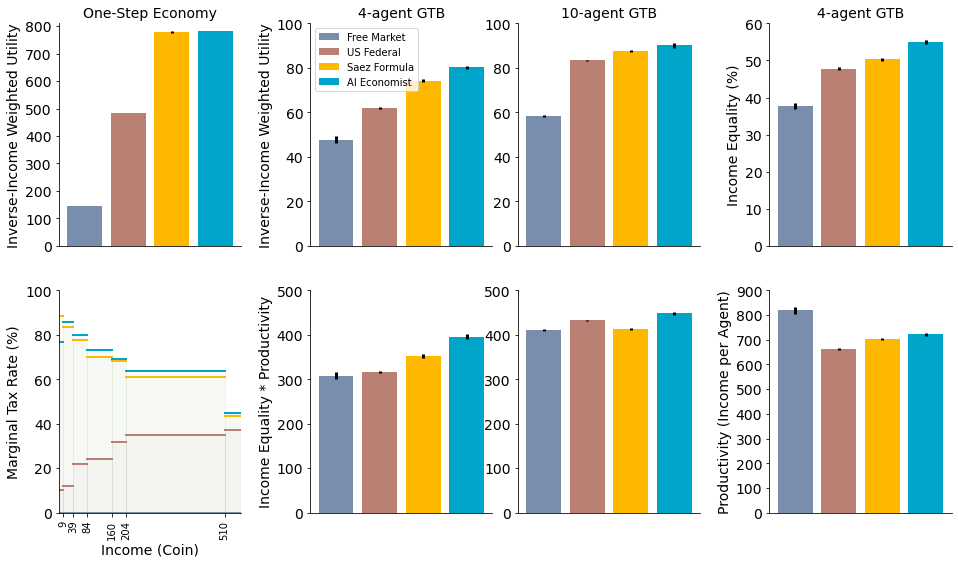

In [23]:
fig = plt.figure(figsize=(16, 9))
    
gs = GridSpec(2, 6, width_ratios=[1, 0.1, 1, 1, 0.1, 1], wspace=0.2)

ax_ose_iiwu = fig.add_subplot(gs[0, 0])
ax_ose_rate = fig.add_subplot(gs[1, 0])

ax_q4_iiwu = fig.add_subplot(gs[0, 2])
ax_q4_eqtp = fig.add_subplot(gs[1, 2])

ax_q10_iiwu = fig.add_subplot(gs[0, 3], sharey=ax_q4_iiwu)
ax_q10_eqtp = fig.add_subplot(gs[1, 3], sharey=ax_q4_eqtp)

ax_q4_e = fig.add_subplot(gs[0, 5])
ax_q4_p = fig.add_subplot(gs[1, 5])

########### One-Step Economy #############
# Inverse-Income Weighted Utility
_, _, rawdata_ose_iiwu = bar_plot_from_history(
    one_step_history,
    run_sets=['fm', 'us', 'saez', 'aie'],
    metric='Inverse-Income Weighted Utility',
    ylabel='Inverse-Income Weighted Utility',
    title='One-Step Economy',
    ax=ax_ose_iiwu,
)
ax_ose_iiwu.set_ylim([0, 810]);

# Tax rates
rate_plot_from_history(
    one_step_history,
    run_sets=['fm', 'us', 'saez', 'aie'],
    ax=ax_ose_rate,
)

########### Open Quad, IIWU #############
# 4-agent
_, _, rawdata_q4_iiwu = bar_plot_from_history(
    quad_4_history,
    run_sets=['fm', 'us', 'saez', 'aie (iiwu)'],
    metric='Inverse-Income Weighted Utility',
    ylabel='Inverse-Income Weighted Utility',
    title='4-agent GTB',
    ax=ax_q4_iiwu,
)
ax_q4_iiwu.legend(loc='upper left');

# 10-agent
_, _, rawdata_q10_iiwu = bar_plot_from_history(
    quad_10_history,
    run_sets=['fm', 'us', 'saez (iiwu)', 'aie (iiwu)'],
    metric='Inverse-Income Weighted Utility',
    title='10-agent GTB',
    ax=ax_q10_iiwu,
)
ax_q10_iiwu.set_ylim([0, 100]);

########### Open Quad, Eq * Prod #############
# 4-agent
_, _, rawdata_q4_eqtp = bar_plot_from_history(
    quad_4_history,
    run_sets=['fm', 'us', 'saez', 'aie (eq*prod)'],
    metric='Income Equality * Productivity',
    ylabel='Income Equality * Productivity',
    ax=ax_q4_eqtp,
)

# 10-agent
_, _, rawdata_q10_eqtp = bar_plot_from_history(
    quad_10_history,
    run_sets=['fm', 'us', 'saez (eq*prod)', 'aie (eq*prod)'],
    metric='Income Equality * Productivity',
    ax=ax_q10_eqtp,
)
ax_q10_eqtp.set_ylim([0, 500]);

########### Open Quad w/ 4 agents, Equality & Productivity #############
# Equality
_, _, rawdata_q4_e = bar_plot_from_history(
    quad_4_history,
    run_sets=['fm', 'us', 'saez', 'aie (eq*prod)'],
    metric='Income Equality',
    ylabel='Income Equality (%)',
    title='4-agent GTB',
    ax=ax_q4_e,
    scale=100,
)
ax_q4_e.set_ylim([0, 60]);

# Productivity
_, _, rawdata_q4_p = bar_plot_from_history(
    quad_4_history,
    run_sets=['fm', 'us', 'saez', 'aie (eq*prod)'],
    metric='Productivity',
    ylabel='Productivity (Income per Agent)',
    ax=ax_q4_p,
    scale=1/4,
)
ax_q4_p.set_ylim([0, 900]);
    
########################
clean_figure(fig)

### Quantitative results in a one-step economy and the Open-Quadrant Gather-Trade-Build environment.

**Left**: The results of the AI Economist and the Saez tax are highly consistent in the one-step economy, both in terms of utilitarian social welfare (upper left) and the tax schedule (lower left).

**Middle**: In the Gather-Trade-Build environment (GTB) with 4 and 10 agents, the AI Economist outperforms baselines when optimizing the utilitarian social welfare objective (upper middle) and when optimizing the equality-times-productivity objective (lower middle).

**Right**: Overall coin equality (upper right) and average productivity (lower right) achieved by each tax model in the 4-agent Open Quadrant scenario. Each bar represents the average end-of-training metrics over 10 random seeds (5 for the one-step economy), with error bars denoting standard error.

All social welfare, productivity, and equality differences between the AI Economist and baselines are statistically significant **(see next cell)**, except for the difference in social welfare between the AI Economist and the Saez tax in the one-step economy (upper left).

In [24]:
print_ttest(rawdata_ose_iiwu, 'One-Step Economy - IIWU')

print_ttest(rawdata_q4_iiwu, '4-agent GTB - IIWU')

print_ttest(rawdata_q4_eqtp, '4-agent GTB - Eq. * Prod.')

print_ttest(rawdata_q10_iiwu, '10-agent GTB - IIWU')

print_ttest(rawdata_q10_eqtp, '10-agent GTB - Eq. * Prod.')

print_ttest(rawdata_q4_e, '4-agent GTB - Income Equality')

print_ttest(rawdata_q4_p, '4-agent GTB - Productivity')


One-Step Economy - IIWU                 AI Economist:  783.256, ind. t-test p_value:
                                         Free Market:  144.442,  2.067e-13
                                          US Federal:  483.537,  2.523e-11
                                        Saez Formula:  777.794,  2.893e-01


4-agent GTB - IIWU                      AI Economist:   80.227, ind. t-test p_value:
                                         Free Market:   47.743,  6.404e-13
                                          US Federal:   62.096,  1.597e-13
                                        Saez Formula:   74.249,  9.256e-06


4-agent GTB - Eq. * Prod.               AI Economist:  395.585, ind. t-test p_value:
                                         Free Market:  308.013,  9.329e-08
                                          US Federal:  317.099,  1.371e-10
                                        Saez Formula:  352.280,  1.070e-05


10-agent GTB - IIWU                     AI Economist:   90.200,

##  
##  
## Paper Figure: Comprehensive quantitative results in the Gather-Trade-Build environment with the utilitarian or equality-times-productivity planner objective, across all settings: Open-Quadrant and 4 Split-World scenarios; 4 and 10 agents.

In [25]:
scenarios = {
    'Open-Quadrant\n4-agent': quad_4_history,
    'Open-Quadrant\n10-agent': quad_10_history,
    'Split-World: 0, 1, 2\n10-agent': split_012_history,
    'Split-World: 2, 7\n10-agent': split_27_history,
    'Split-World: 4, 5\n10-agent': split_45_history,
    'Split-World: 7, 8, 9\n10-agent': split_789_history,
}

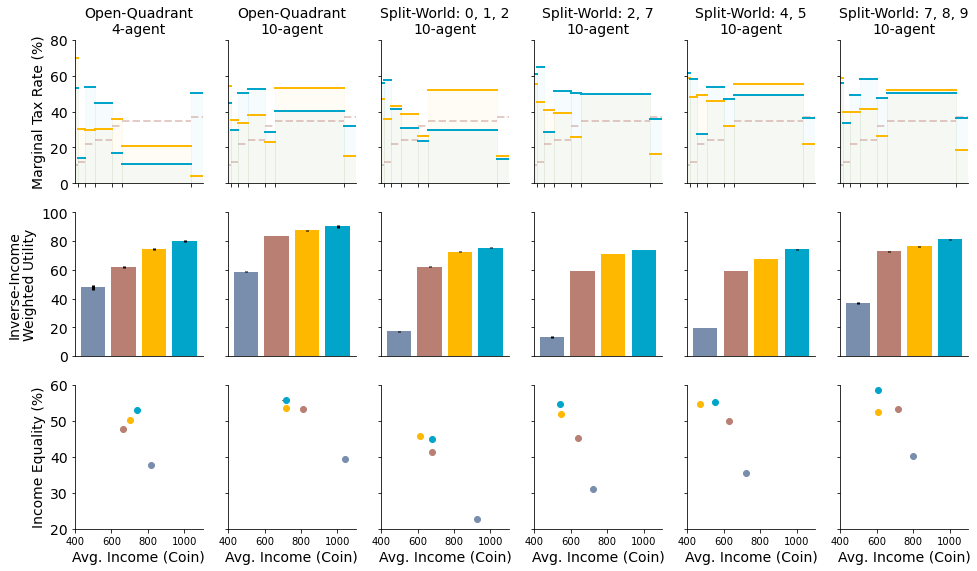

In [26]:
fig = plt.figure(figsize=(16, 9))

gs = GridSpec(3, len(scenarios))

# Store raw data here for doing t-tests
rawdata_iiwu = {}

for s_idx, (scenario_title, scenario_history) in enumerate(scenarios.items()):
    # Create the relevant subplots
    ax0 = fig.add_subplot(gs[0, s_idx])
    ax1 = fig.add_subplot(gs[1, s_idx])
    ax2 = fig.add_subplot(gs[2, s_idx])
    
    # Some plotting setup
    scenario_key, agent_tag = scenario_title.split('\n')
    n_agents = float(agent_tag.split('-')[0])
    
    saez_iiwu = 'saez (iiwu)' if 'saez (iiwu)' in scenario_history else 'saez'
    run_sets = ['fm', 'us', saez_iiwu, 'aie (iiwu)']
    
    # Plot tax rates (include US Federal, with low visual weight)
    rate_plot_from_history(scenario_history, ['us'], label_y=False, label_x=False, 
                           ax=ax0, rectangle_alpha=0.0, linestyle='--', alpha=0.4)
    rate_plot_from_history(scenario_history, run_sets[2:], title=scenario_title,
                           label_x=False, label_y=s_idx==0, ax=ax0)
    ax0.set_ylim([0, 80]);
    ax0.set_xticklabels(['']*6);
    
    # Plot social welfare (in this case, Inverse-Income Weighted Utility)
    _, _, rawdata_iiwu['{}-agt. {}'.format(int(n_agents), scenario_key)] = bar_plot_from_history(
        scenario_history, run_sets, 
        metric='Inverse-Income Weighted Utility',
        ylabel='Inverse-Income\nWeighted Utility' if s_idx==0 else '',
        ax=ax1
    )
    ax1.set_ylim([0, 100]);
    
    # Plot Income Equality versus Productivity
    eq_prod_scatter_from_history(scenario_history, run_sets, n_agents, ax=ax2)
    ax2.set_ylim([20, 60]);
    ax2.set_xlim([400, 1100]);
    
    if s_idx > 0:
        for ax in [ax0, ax1, ax2]:
            ax.set_yticklabels(['' for _ in ax.get_yticklabels()])
    
clean_figure(fig)

### (Top half of) Comprehensive quantitative results in the Gather-Trade-Build environment with the utilitarian or equality-times-productivity planner objective, across all settings: Open-Quadrant and 4 Split-World scenarios; 4 and 10 agents.

The AI Economist achieves substantially higher social welfare than all baselines.

**Top row**: Tax schedules for the Saez tax (yellow) and the AI Economist (blue). US Federal (which are the same throughout) are shown in dashed red.

**Middle row**: Utilitarian social welfare objective (inverse-income weighted utility) for all planners.

**Bottom row**: Equality and productivity for all planners. For the data in the above 3 rows, the AI Economist is trained to maximize the utilitarian social welfare objective, and the Saez taxes use the best-performing elasticity for the utilitarian objective. 

Bars and dots represent the average end-of-training metrics over 10 (5) random seeds for the Open-Quadrant (Split-World) scenarios, with error bars denoting standard error. The color legend is:
- Gray: Free Market
- Red: US Federal
- Yellow: Saez Formula
- Blue: AI Economist

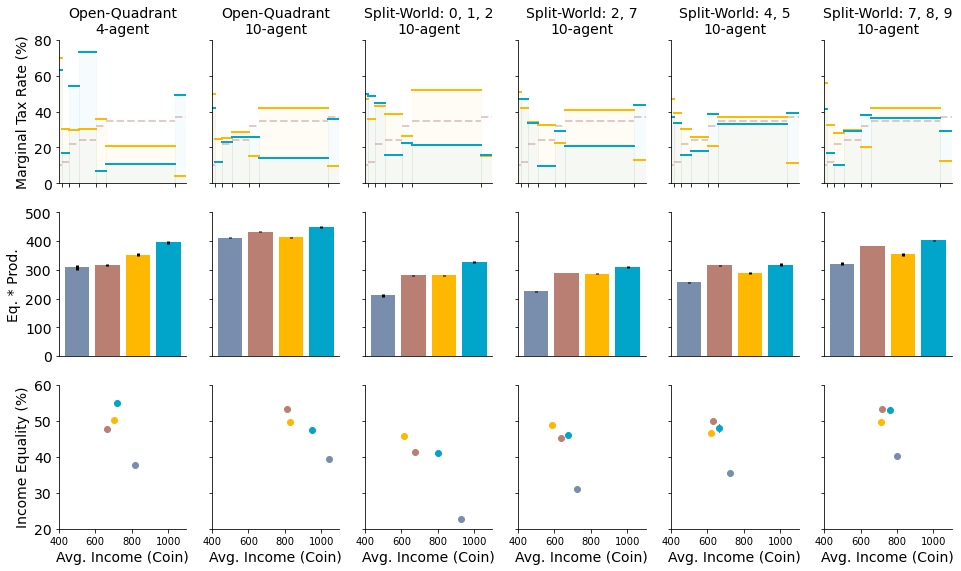

In [27]:
fig = plt.figure(figsize=(16, 9))

gs = GridSpec(3, len(scenarios))

# Store raw data here for doing t-tests
rawdata_eqtp = {}

for s_idx, (scenario_title, scenario_history) in enumerate(scenarios.items()):
    # Create the relevant subplots
    ax0 = fig.add_subplot(gs[0, s_idx])
    ax1 = fig.add_subplot(gs[1, s_idx])
    ax2 = fig.add_subplot(gs[2, s_idx])
    
    # Some plotting setup
    scenario_key, agent_tag = scenario_title.split('\n')
    n_agents = float(agent_tag.split('-')[0])
    
    saez_eqtp = 'saez (eq*prod)' if 'saez (eq*prod)' in scenario_history else 'saez'
    run_sets = ['fm', 'us', saez_eqtp, 'aie (eq*prod)']
    
    # Plot tax rates (include US Federal, with low visual weight)
    rate_plot_from_history(scenario_history, ['us'], label_y=False, label_x=False, 
                           ax=ax0, rectangle_alpha=0.0, linestyle='--', alpha=0.4)
    rate_plot_from_history(scenario_history, run_sets[2:], title=scenario_title,
                           label_x=False, label_y=s_idx==0, ax=ax0)
    ax0.set_ylim([0, 80]);
    ax0.set_xticklabels(['']*6);
    
    # Plot social welfare (in this case, Inverse-Income Weighted Utility)
    _, _, rawdata_eqtp['{}-agt. {}'.format(int(n_agents), scenario_key)] = bar_plot_from_history(
        scenario_history, run_sets, 
        metric='Income Equality * Productivity',
        ylabel='Eq. * Prod.' if s_idx==0 else '',
        ax=ax1
    )
    ax1.set_ylim([0, 500]);
    
    # Plot Income Equality versus Productivity
    eq_prod_scatter_from_history(scenario_history, run_sets, n_agents, ax=ax2)
    ax2.set_ylim([20, 60]);
    ax2.set_xlim([400, 1100]);
    
    if s_idx > 0:
        for ax in [ax0, ax1, ax2]:
            ax.set_yticklabels(['' for _ in ax.get_yticklabels()])
    
clean_figure(fig)

### (Bottom half of) Comprehensive quantitative results in the Gather-Trade-Build environment with the utilitarian or equality-times-productivity planner objective, across all settings: Open-Quadrant and 4 Split-World scenarios; 4 and 10 agents.

**Top, middle, and bottom rows**: Same as above set of plots, but for these data the AI Economist is trained to maximize the equality-times-productivity social welfare objective, and the Saez taxes use the best-performing elasticity for this objective, which is shown in the bar plots of the middle row. 

Bars and dots represent the average end-of-training metrics over 10 (5) random seeds for the Open-Quadrant (Split-World) scenarios, with error bars denoting standard error. The color legend is:
- Gray: Free Market
- Red: US Federal
- Yellow: Saez Formula
- Blue: AI Economist

All social welfare differences between the AI Economist and baselines are statistically significant **(see next cell)**, except for the difference in equality-times-productivity between the AI Economist and the US Federal tax in the Split-World-4,5 scenario.

In [28]:
for scenario_label, rawdata in rawdata_iiwu.items():
    print_ttest(rawdata, scenario_label + ' - IIWU')

for scenario_label, rawdata in rawdata_eqtp.items():
    print_ttest(rawdata, scenario_label + ' - Eq*P')


4-agt. Open-Quadrant - IIWU             AI Economist:   80.227, ind. t-test p_value:
                                         Free Market:   47.743,  6.404e-13
                                          US Federal:   62.096,  1.597e-13
                                        Saez Formula:   74.249,  9.256e-06


10-agt. Open-Quadrant - IIWU            AI Economist:   90.200, ind. t-test p_value:
                                         Free Market:   58.533,  8.275e-16
                                          US Federal:   83.398,  1.465e-05
                                        Saez Formula:   87.563,  3.845e-02


10-agt. Split-World: 0, 1, 2 - IIWU     AI Economist:   75.301, ind. t-test p_value:
                                         Free Market:   17.130,  8.844e-14
                                          US Federal:   62.198,  3.155e-09
                                        Saez Formula:   72.689,  2.678e-03


10-agt. Split-World: 2, 7 - IIWU        AI Economist:   73.903,

##  
##  
## Paper Figure: Comparison of tax policies in the 4-agent Open-Quadrant Gather-Trade-Build environment. 

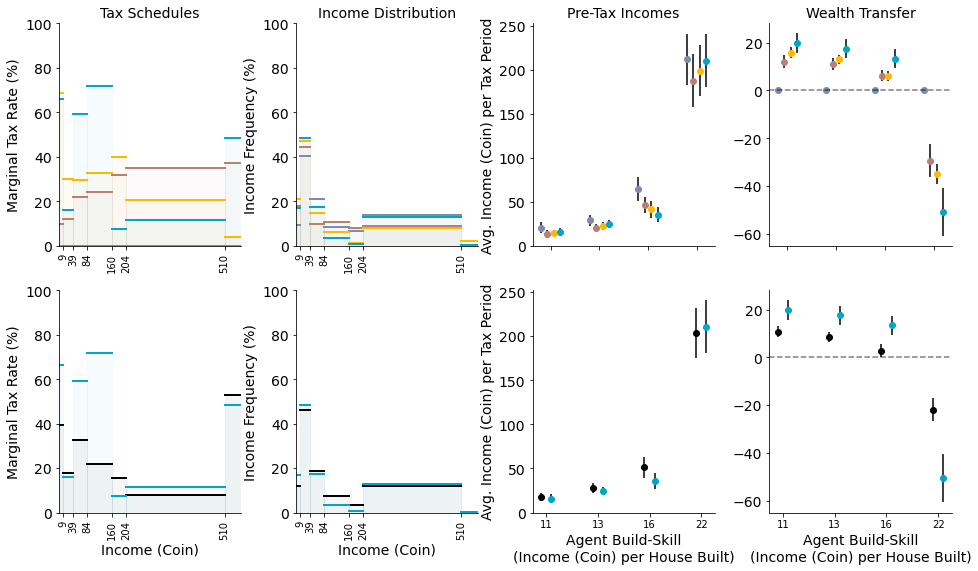

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(16, 9))

tax_groups = ['Free Market', 'US Federal', 'Saez Formula', 'AI Economist']
training_groups = ['AI Economist (early)', 'AI Economist']

for i, group_set in enumerate([tax_groups, training_groups]):
    ########### Tax schedules #############
    rate_plot_from_stats(
        quad_4_stats_dict,
        groups=group_set,
        title='Tax Schedules' if i==0 else None,
        label_x=i==1,
        ax=axes[i, 0]
    );

    ########### Income distribution #############
    rate_plot_from_stats(
        quad_4_stats_dict,
        groups=group_set,
        occupancy=True,
        title='Income Distribution' if i==0 else None,
        label_x=i==1,
        ax=axes[i, 1]
    );

    ########### Agent-wise incomes #############
    agent_point_plot_from_stats(
        quad_4_stats_dict,
        'pre_tax_income',
        groups=group_set,
        scale=1/10,
        label_x=i==1,
        ylabel='Avg. Income (Coin) per Tax Period',
        title='Pre-Tax Incomes' if i==0 else None,
        ax=axes[i, 2]
    );

    ########### Agent-wise net taxes #############
    agent_point_plot_from_stats(
        quad_4_stats_dict,
        'net_tax_paid',
        groups=group_set,
        scale=-1/10,
        label_x=i==1,
        title='Wealth Transfer' if i==0 else None,
        ax=axes[i, 3]
    );

##################################
plt.subplots_adjust(wspace=0.3);
clean_figure(fig)

### Comparison of tax policies in the 4-agent Open-Quadrant Gather-Trade-Build environment. 

**Left**: Average marginal tax rates within each tax bracket. 

**Middle, left**: Frequency with which agent incomes fall within each bracket.

**Middle, right**: Average pre-tax income of each agent (sorted by build-skill) under each of the tax models.

**Right**: Average wealth transfer resulting from taxation and redistribution.

**Bottom rows**: Same as top rows, comparing the AI Economist from early during training (250 million training samples; black) versus at the end of training (1 billion training samples; blue).

Dots denote averages and error bars denote standard deviation across episodes. The color legend is:
- Gray: Free Market
- Red: US Federal
- Yellow: Saez Formula
- Blue: AI Economist
- Black: AI Economist (early during training)

##  
##  
## Paper Figure: Specialization, interactions, and tax gaming in the 4-agent Open-Quadrant Gather-Trade-Build environment.

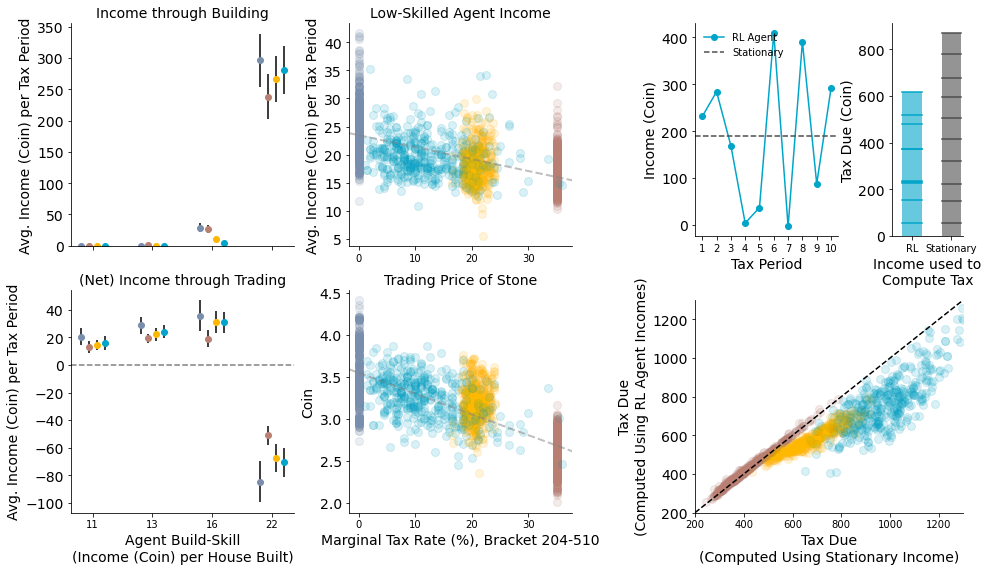

In [30]:
fig = plt.figure(figsize=(16, 9))

gs = GridSpec(2, 4, width_ratios=[1, 1, 0.06, 1.2], wspace=0.3)

ax_build_inc = fig.add_subplot(gs[0, 0])
ax_trade_inc = fig.add_subplot(gs[1, 0])
ax_scatter_income = fig.add_subplot(gs[0, 1])
ax_scatter_price = fig.add_subplot(gs[1, 1])

tax_groups = ['Free Market', 'US Federal', 'Saez Formula', 'AI Economist']

########### Income sources #############
agent_point_plot_from_stats(
    quad_4_stats_dict,
    'net_build_income',
    groups=tax_groups,
    scale=0.1,
    ylabel='Avg. Income (Coin) per Tax Period',
    title='Income through Building',
    label_x=False,
    ax=ax_build_inc
)
agent_point_plot_from_stats(
    quad_4_stats_dict,
    'net_trade_income',
    groups=tax_groups,
    scale=0.1,
    ylabel='Avg. Income (Coin) per Tax Period',
    title='(Net) Income through Trading',
    ax=ax_trade_inc
)

############ Interaction effects via trading ############
scatter_plot_from_stats(
    quad_4_stats_dict,
    x=lambda d: d['avg_tax_schedule'][5]*100,
    y=lambda d: np.mean(d['pre_tax_income'][:2])/10,
    groups=tax_groups,
    ylabel='Avg. Income (Coin) per Tax Period',
    title='Low-Skilled Agent Income',
    aggregate_trendline=True,
    ax=ax_scatter_income,
)
scatter_plot_from_stats(
    quad_4_stats_dict,
    x=lambda d: d['avg_tax_schedule'][5]*100,
    y='avg_stone_price',
    groups=tax_groups,
    xlabel='Marginal Tax Rate (%), Bracket 204-510',
    title='Trading Price of Stone',
    ylabel='Coin',
    aggregate_trendline=True,
    ax=ax_scatter_price,
)

############ Tax gaming ############
tax_gaming_plot(quad_4_stats_dict, tax_gaming_dense_log, fig=fig, parent_gridspec=gs[:, -1])

##########################
clean_figure(fig)

### Specialization, interactions, and tax gaming in the 4-agent Open-Quadrant Gather-Trade-Build environment.

**Left**: Average net income from building (upper left) and trading (lower left) of each agent. Negative values denote net expenditure. Dots denote averages and error bars denote standard deviation.

**Middle**: The income of the two lowest build-skill agents (upper middle) and average trading price (lower middle) decrease as the tax rate in the higher 204-510 tax bracket increases, even though the agents’ incomes are below the cutoff for this bracket. Hence, the trading behavior of high-skilled agents affects the income of the low-skilled agents. The standard definition of elasticity does not capture this interaction effect. Each dot represents a single episode.

**Right**: RL agents learn to strategize across each of the 10 tax years, lowering their total payable tax compared to a smoothed strategy that earns the same, average income in each year: the top panels illustrate this for a single episode; the bottom panel shows the saving relative to a smoothed income across all episodes used in the analysis. We do not observe this tax gaming under the progressive US Federal tax schedule.

The color legend is:
- Gray: Free Market
- Red: US Federal
- Yellow: Saez Formula
- Blue: AI Economist
- Black: AI Economist (early during training)

##  
##  
## Paper Figure: Trading and economic performance, including tax revenue, in the 4-agent Open-Quadrant Gather-Trade-Build environment.

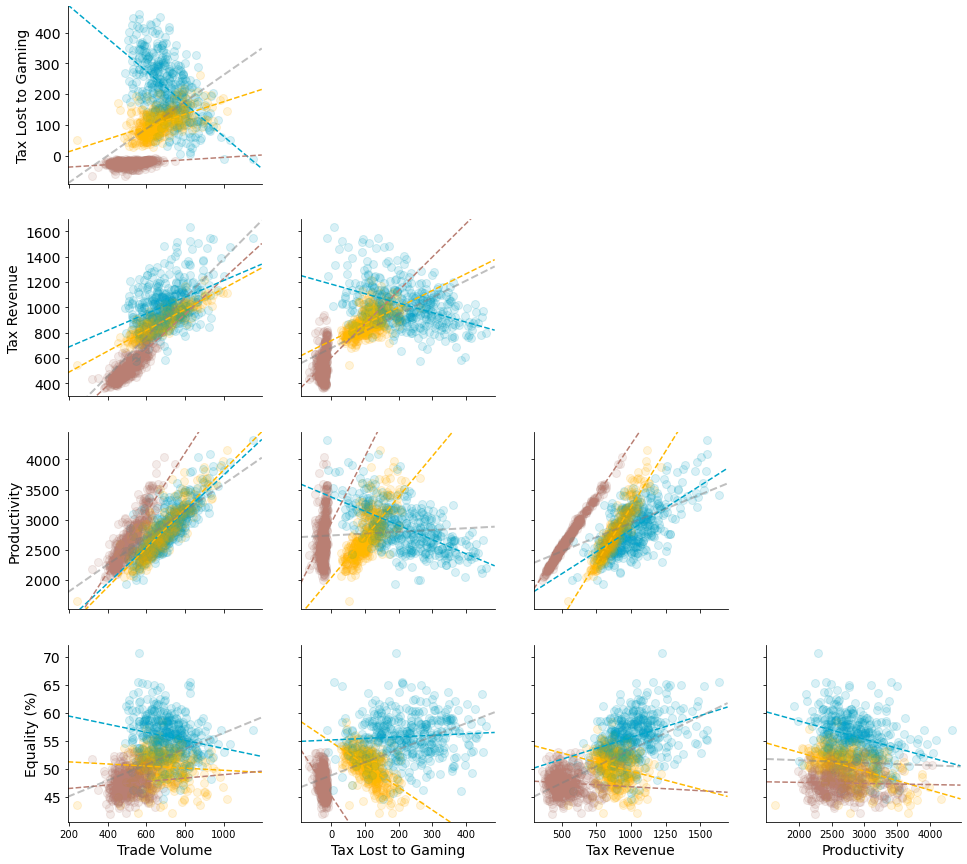

In [31]:
function_label_tuples = [
    (get_trade_volume, 'Trade Volume'),
    (get_gaming_gap, 'Tax Lost to Gaming'),
    (get_tax_revenue, 'Tax Revenue'),
    (get_productivity, 'Productivity'),
    (get_percent_equality, 'Equality (%)'),
]

fig, axes = plt.subplots(
    len(function_label_tuples)-1, len(function_label_tuples)-1,
    figsize=(16, 15),
    sharex='col', sharey='row'
)

########################
for ix, (fx, lx) in enumerate(function_label_tuples[:-1]):
    for iy, (fy, ly) in enumerate(function_label_tuples[1:]):
        ax = axes[iy, ix]
        
        if ix > iy:
            ax.set_visible(False)
            continue
            
        scatter_plot_from_stats(
            quad_4_stats_dict,
            groups=['US Federal', 'Saez Formula', 'AI Economist'],
            x=fx,
            y=fy,
            xlabel=lx,
            ylabel=ly,
            aggregate_trendline=True,
            group_trendlines=True,
            ax=ax,
        )
        if not ax.is_last_row():
            ax.set_xlabel('');
        if not ax.is_first_col():
            ax.set_ylabel('');
            
########################
clean_figure(fig)

### Trading and economic performance, including tax revenue, in the 4-agent Open-Quadrant Gather-Trade-Build environment.

The scatter plots show the empirical relationships between trading, tax gaming, tax revenue, productivity, and equality. Each dot represents a single simulation episode in the 4-agent, Open Quadrant setting. Colored dashed lines provide trend lines (via linear regression) for the data with the matching color. The gray dashed line provides an aggregate trend line for the combined data. All metrics (except for equality) are measured in Coins.
- Trade Volume measures the total (positive) income through trading.
- Tax Lost to Gaming measures the difference between the total tax revenue and the hypothetical tax revenue if there were no temporal variation in incomes.
- Tax Revenue measures the total taxes collected during the episode.
- Productivity measures the total income generated during the episode.
- Equality measures the equality of post-tax incomes, where 100% equals perfect equality.

The color legend is:
- Gray: Free Market
- Red: US Federal
- Yellow: Saez Formula
- Blue: AI Economist
- Black: AI Economist (early during training)

# Tax Schedule Distance Analysis

In [32]:
bracket_keys = [
    'Avg. Bracket Rate: 0',
    'Avg. Bracket Rate: 9',
    'Avg. Bracket Rate: 39',
    'Avg. Bracket Rate: 84',
    'Avg. Bracket Rate: 160',
    'Avg. Bracket Rate: 204',
    'Avg. Bracket Rate: 510',
]

def extract_run_rates(training_history_dict, group=None, n_back=1000):
    if group is None:
        group = 'eq*prod'
    data = training_history_dict['aie ({})'.format(group)]['data']
    
    run_rates = []
    for run_data in data:
        rates = []
        for key in bracket_keys:
            rates.append(np.mean(run_data[key][-n_back:]))
        run_rates.append(rates)
    return np.array(run_rates)

def distance_matrix(run_rates_a, run_rates_b):
    distances = -np.ones((run_rates_a.shape[0], run_rates_b.shape[0]))
    for i, rates_a in enumerate(run_rates_a):
        for j, rates_b in enumerate(run_rates_b):
            d = np.sqrt(np.sum((rates_a - rates_b)**2))
            distances[i, j] = d
    return distances

def raw_tax_distances(setting_a, setting_b):
    assert isinstance(setting_a, (tuple, list))
    assert len(setting_a) == 2
    
    assert isinstance(setting_b, (tuple, list))
    assert len(setting_b) == 2
    ds = distance_matrix(extract_run_rates(*setting_a), extract_run_rates(*setting_b))
    
    if setting_b != setting_a:
        return ds.flatten()
    
    tmp = np.triu(ds, k=1).flatten()
    return tmp[tmp > 0]

def average_tax_distance(setting_a, setting_b):
    if isinstance(setting_a, dict):
        setting_a = (setting_a, None)
    else:
        assert isinstance(setting_a, (tuple, list))
        assert len(setting_a) == 2
    if isinstance(setting_b, dict):
        setting_b = (setting_b, None)
    else:
        assert isinstance(setting_b, (tuple, list))
        assert len(setting_b) == 2
    ds = distance_matrix(extract_run_rates(*setting_a), extract_run_rates(*setting_b))
    
    if setting_b != setting_a:
        return np.mean(ds.flatten())
    
    tmp = np.triu(ds, k=1).flatten()
    return np.mean(tmp[tmp > 0])

In [33]:
def plot_rates(rates, color, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    # xs = bracket cutoffs -- in terms of income (coins)
    xs = [0, 9, 39, 84, 160, 204, 510]
    xs += [xs[-1] * 1.1]
    
    brackets = []

    for i in range(len(xs)-1):
        rect = Rectangle((xs[i], 0), xs[i+1]-xs[i], 100*rates[i], color=color, alpha=0.1)
        ax.add_patch(rect);
        ax.plot([xs[i], xs[i+1]], [100*rates[i], 100*rates[i]], color=color, linewidth=2)
        
    ax.set_ylim([0, 100]);
    ax.set_xlim([-5, xs[-1]+5]);
    ax.set_xlabel('Income (Coin)', fontsize=14);
    ax.set_ylabel('Avg. Marginal Tax Rate (%)', fontsize=14);

In [34]:
# Extract all the same- and different-setting L2-distances and select representative pairs.

setting_histories = [
    quad_4_history, quad_10_history, split_012_history, split_27_history, split_45_history, split_789_history
]
settings = []
for s_hist in setting_histories:
    settings.append((s_hist, 'eq*prod'))
    settings.append((s_hist, 'iiwu'))

same_ds = []
diff_ds = []
for i, setting_a in enumerate(settings):
    for setting_b in settings[i:]:
        
        raw_ds = raw_tax_distances(setting_a, setting_b)
        
        if setting_a == setting_b:
            same_ds.append(raw_ds)

        else:
            diff_ds.append(raw_ds)
            
same_ds = np.concatenate(same_ds)
diff_ds = np.concatenate(diff_ds)

# Get the L2-distance matrix for *all* the runs
run_rates = []
for setting in settings:
    run_rates.append(extract_run_rates(*setting))
run_rates = np.concatenate(run_rates)

dmat_all = distance_matrix(run_rates, run_rates)
idx0s, idx1s = np.triu_indices_from(dmat_all, k=1)

i_med_same = np.argsort((dmat_all[idx0s, idx1s] - np.median(same_ds))**2)[2]
i_med_diff = np.argsort((dmat_all[idx0s, idx1s] - np.median(diff_ds))**2)[2]

##  
##  
## Paper Figure: Comparing learned AI tax policies for the same and across different settings.

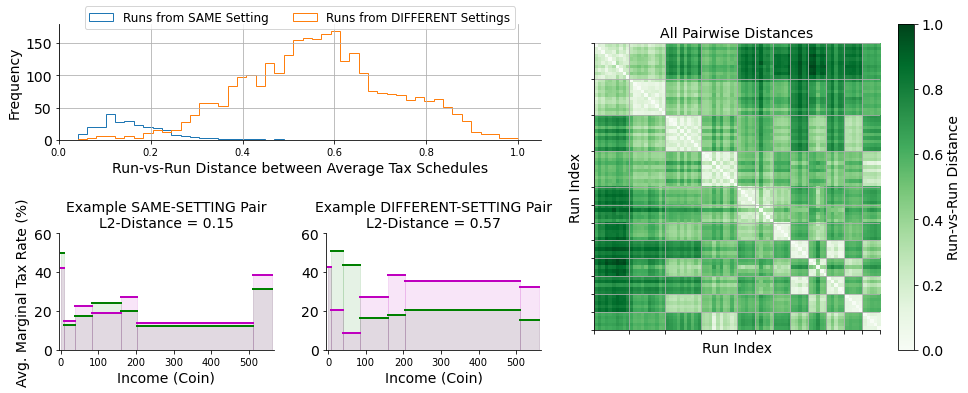

In [35]:
fig = plt.figure(figsize=(16, 6))
    
gs = GridSpec(2, 3, width_ratios=[0.6, 0.6, 1], wspace=0.2)

ax0 = fig.add_subplot(gs[0, :2])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[:, 2])

xs = np.linspace(0, 1)

########## Histogram ###########
ax0.hist(same_ds, bins=xs, histtype='step', label='Runs from SAME Setting');
ax0.hist(diff_ds, bins=xs, histtype='step', label='Runs from DIFFERENT Settings');
ax0.set_xlabel('Run-vs-Run Distance between Average Tax Schedules', fontsize=14);
ax0.set_ylabel('Frequency', fontsize=14);
ax0.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2);
ax0.grid(b=True);
ax0.set_xlim(left=0);
ax0.set_ylim([0, 180]);

########## Example schedules ###########
plot_rates(run_rates[idx0s[i_med_same]], 'g', ax=ax1)
plot_rates(run_rates[idx1s[i_med_same]], 'm', ax=ax1)
ax1.set_title(
    'Example SAME-SETTING Pair\nL2-Distance = {:4.2f}'.format(dmat_all[idx0s[i_med_same], idx1s[i_med_same]]), 
    fontsize=14
);
ax1.set_ylim(top=60);

plot_rates(run_rates[idx0s[i_med_diff]], 'g', ax=ax2)
plot_rates(run_rates[idx1s[i_med_diff]], 'm', ax=ax2)
ax2.set_title(
    'Example DIFFERENT-SETTING Pair\nL2-Distance = {:4.2f}'.format(dmat_all[idx0s[i_med_diff], idx1s[i_med_diff]]),
    fontsize=14
);
ax2.set_ylim(top=60);
ax2.set_ylabel('');

########## L2-distance heatmap ###########
cbar = plt.colorbar(
    ax3.imshow(dmat_all, vmin=0, vmax=1, interpolation='none', aspect='equal', cmap='Greens'),
    ax=ax3
);

ts = [-0.5]
for setting in settings:
    n = extract_run_rates(*setting).shape[0]
    ts.append(float(ts[-1]+n))
    
ax3.set_yticks(ts);
ax3.set_xticks(ts);
ax3.set_yticklabels([]);
ax3.set_xticklabels([]);
ax3.grid(b=True);
ax3.set_xlabel('Run Index');
ax3.set_ylabel('Run Index');
ax3.set_title('All Pairwise Distances');
cbar.set_label('Run-vs-Run Distance');

#############################
plt.subplots_adjust(hspace=0.8);
clean_figure(fig)

### Comparing learned AI tax policies for the same and across different settings. 

**Top left**: Distribution of L2-distances between tax schedules for each pair of distinct AI Economist runs across all twelve Gather-Trade-Build settings (each combination of the six spatial layouts and two planner objectives). Pairs from the same setting are plotted in blue, with pairs from different settings plotted in orange. Different- versus same-setting distances are statistically different (p < 1e−200 under an independent t-test), and their distributions are highly discriminable (ROC-AUC = 0.98). **See next cell for computation.**

**Right**: Heatmap representation of the data in top left histogram, with color intensity varying according to the L2-distance between the row and column pair of runs. The grid lines denote run indices belonging to the same setting, highlighting the block-wise diagonal structure. Note: Open-Quadrant settings have 10 runs each and Split settings have 5 runs each, which is why the grid lines and blocks are not uniformly sized.

**Bottom left**: Tax schedules for a representative same-setting pair (left pair) and a representative different-setting pair (right pair). The L2-distance of the same-setting pair approximately equals the median same-setting distance (0.15). The L2-distance of the different-setting pair approximately equals the median different-setting distance (0.57).

In [36]:
print('Same- vs Different-setting L2-distances:')

# Independent t-test
ttest_results = scipy.stats.ttest_ind(same_ds, diff_ds)
print('\tindependent t-test, p-value = {}'.format(ttest_results.pvalue))

# ROC analysis (prints Area Under the Curve)
y_labels = np.concatenate([np.zeros_like(same_ds), np.ones_like(diff_ds)])
y_scores = np.concatenate([same_ds, diff_ds])
auc = metrics.roc_auc_score(y_labels, y_scores)
print('\tROC analysis, Area Under Curve = {}'.format(auc))

Same- vs Different-setting L2-distances:
	independent t-test, p-value = 1.0958020773762475e-275
	ROC analysis, Area Under Curve = 0.9840755968169761


##  
##  
## Paper Figure: Reward achieved during training.

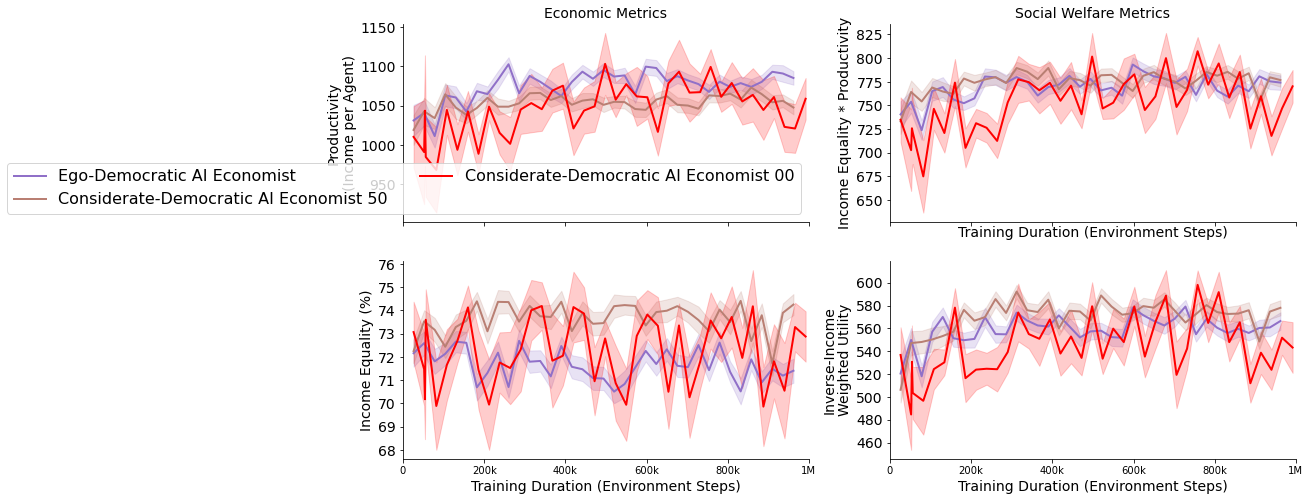

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

# run_sets = ['saez', 'aie', 'ego-dem-aie', 'con-dem-aie-50', 'con-dem-aie-100']
run_sets = ['ego-dem-aie', 'con-dem-aie-50', 'con-dem-aie-00']

with open('new_analysis/one-step-economy/saez/training_history.pkl', 'rb') as f:
        saez = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist/training_history.pkl', 'rb') as f:
        aie = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist-egoistic-democracy/training_history.pkl', 'rb') as f:
        ego_dem_aie = pickle.load(f)

with open('new_analysis/one-step-economy/ai-economist-considerate-democracy/training_history.pkl', 'rb') as f:
        con_dem_aie50 = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist-considerate-democracy/purely_utilitarian/training_history.pkl', 'rb') as f:
        con_dem_aie100 = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist-considerate-democracy/purely_egoistic/training_history.pkl', 'rb') as f:
        con_dem_aie00 = pickle.load(f)
        
with open('new_analysis/one-step-economy/fm/training_history.pkl', 'rb') as f:
        fm = pickle.load(f)

training_history = {**saez, **aie, **ego_dem_aie, **con_dem_aie50, **fm, **con_dem_aie100, **con_dem_aie00}

# display(training_history)

########## Economic Metrics ############
# Productivity
training_curve_plot(
    training_history,
    run_sets,
    metric='Productivity',
    ylabel='Productivity\n(Income per Agent)',
    scale=1/9,
    smooth_amount=1,
    max_steps=1000000,
    plot_every = 1,
    label_x=False,
    title='Economic Metrics',
    ax=axes[0, 0],
)
axes[0, 0].legend(loc='lower right', ncol=2, fontsize=16);

# Income equality
training_curve_plot(
    training_history,
    run_sets,
    metric='Income Equality',
    ylabel='Income Equality (%)',
    scale=100,
    smooth_amount=1,
    max_steps=1000000,
    plot_every = 1,
    ax=axes[1, 0],
)

########## Social Welfare Metrics ############
# Equality * Productivity
training_curve_plot(
    training_history,
    run_sets,
    metric='Income Equality * Productivity',
    ylabel='Income Equality * Productivity',
    title='Social Welfare Metrics',
    smooth_amount=1,
    max_steps=1000000,
    plot_every = 1,
    ax=axes[0, 1]
)

# Inverse-Income Weighted Utility
training_curve_plot(
    training_history,
    run_sets,
    metric='Inverse-Income Weighted Utility',
    ylabel='Inverse-Income\nWeighted Utility',
    smooth_amount=1,
    max_steps=1000000,
    plot_every = 1,
    ax=axes[1, 1]
)


#################################        
clean_figure(fig)

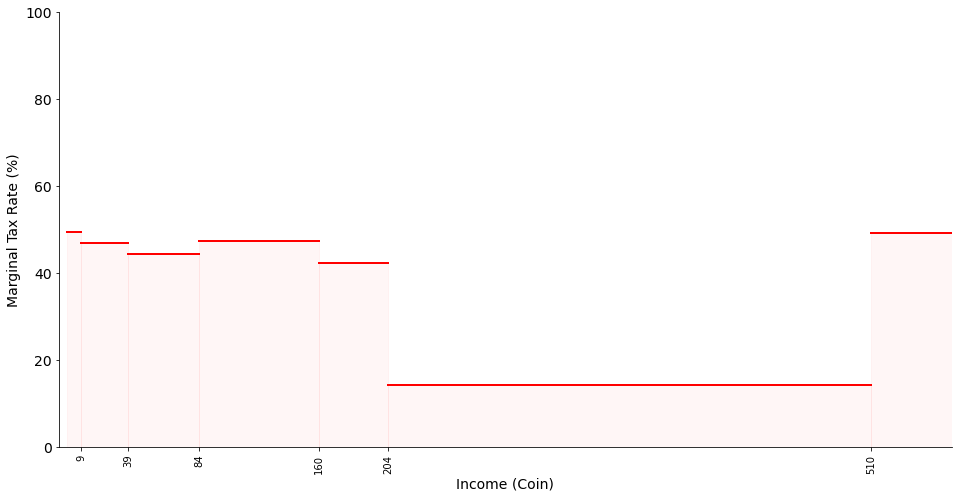

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8), sharex=True)

with open('new_analysis/one-step-economy/saez/training_history.pkl', 'rb') as f:
        saez = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist/training_history.pkl', 'rb') as f:
        aie = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist-egoistic-democracy/training_history.pkl', 'rb') as f:
        ego_dem_aie = pickle.load(f)

with open('new_analysis/one-step-economy/ai-economist-considerate-democracy/training_history.pkl', 'rb') as f:
        con_dem_aie50 = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist-considerate-democracy/purely_utilitarian/training_history.pkl', 'rb') as f:
        con_dem_aie100 = pickle.load(f)
        
with open('new_analysis/one-step-economy/ai-economist-considerate-democracy/purely_egoistic/training_history.pkl', 'rb') as f:
        con_dem_aie00 = pickle.load(f)

training_history = {**saez, **aie, **ego_dem_aie, **con_dem_aie50, **con_dem_aie100, **con_dem_aie00}
        
# display(saez['saez']['data'][0].keys())

# Tax rates
rate_plot_from_history(
    training_history,
    #run_sets=['saez', 'aie', 'ego-dem-aie', 'con-dem-aie-50', 'con-dem-aie-100'],
    run_sets=['con-dem-aie-00'],
    ax=axes,
)


#################################        
clean_figure(fig)

### Reward achieved during training.

Results shown for 10 repetitions with different random seeds. Shading indicates the standard error. For the AI Economist (blue), the training instability due to two-level learning is clearly visible: the planner’s reward (social welfare, in this case Equality * Productivity) oscillates substantially during early training, even after using our structured curriculum learning approach.

